In [1]:
# Imports
import torch
import matplotlib.pyplot as plt
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch.utils.data import Dataset 
from torch.utils.data import random_split 
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import os
import shutil
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from tqdm import tqdm  # For nice progress bar!

from dataGen import Patches
from PIL import Image
import spectral as spec

E:\Software\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ResNet(nn.Module):
    def __init__(self, in_channels=14, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = nn.Sequential(
            nn.Conv2d(14, 64, 1, stride=1, bias=False),
            nn.BatchNorm2d(64),
        )
        
        self.fc1 = nn.Linear(1024, 512)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(512, num_classes)
            
    def forward(self, x):
        identity = x
        x = self.conv1(x)  
        x = self.conv2(x)      
        x = self.bn1(x)
        x += self.downsample(identity)
        x = self.relu(x)
        x = self.maxpool(x)         
        
        identity = x
        x = self.conv3(x)  
        x = self.conv4(x)      
        x = self.bn2(x)
        x += identity
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Hyperparameters
in_channels = 14
num_classes = 2
img_size = 12
learning_rate = 0.0001
batch_size = 128
num_epochs = 60

In [5]:
# Transformers
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.ConvertImageDtype(torch.float)])
img_transform

Compose(
    ToTensor()
    Resize(size=(12, 12), interpolation=bilinear)
    ConvertImageDtype()
)

In [52]:
patch = Patches("D:\\gyeongsang_22_10_21_1\\PATCHES")
patch.describe()

For hdr image, there are: 
 leaf          5933
background    4746
diseased        76
Name: class, dtype: int64
For jpg image, there are: 
 leaf          5933
background    4746
diseased        76
Name: class, dtype: int64


In [53]:
patch_dataset = patch.generateDataset(
    dataset_composition = [
        ['diseased',    76],
        ['leaf',        760],
        ['background',  760]],
    data_type = 'hdr')

patch_dataset.loc[(patch_dataset['class'] == 'background'), 'class'] = 0
patch_dataset.loc[(patch_dataset['class'] == 'leaf'), 'class'] = 0
patch_dataset.loc[(patch_dataset['class'] == 'diseased'), 'class'] = 1

patch_dataset.describe()

,path,type,class
count,1596,1596,1596
unique,1596,1,2
top,D:\gyeongsang_22_10_21_1\PATCHES\MOS_CAL_GEORE...,hdr,0
freq,1,1596,1520


In [54]:
# Custom Image Dataset
class Img(Dataset):
    def __init__(self, img_df, transform=None, s=100):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        img = spec.envi.open(img_path)
        np_img = np.array(img[:, :, [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]])
        label = self.img_df['class'].iloc[idx]
        if self.transform:
            image = self.transform(np_img)
        return image, label

In [55]:
dataset = Img(img_df=patch_dataset, transform=img_transform)
dataset = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [56]:
next(iter(dataset))[0].shape   

torch.Size([128, 14, 12, 12])

In [57]:
def tensorToImg(tensor):
    img = torch.zeros(img_size, img_size, 1)
    for c_y, y in enumerate(tensor[0]):
        for c_x, x in enumerate(y):
            img[c_y][c_x] = x
    return img

In [58]:
def displayImgs(imgs, labels, save=False):
    fig = plt.figure(figsize=(20,11))
    for pos, i in enumerate(imgs[:8]):
        img = tensorToImg(i)
        label = "downy mildew"
        if labels[pos] == 0:
            label = "Non-disease"
        fig.add_subplot(4, 8, pos + 1).title.set_text(label)
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    if save:
        fig.savefig('fig.png')

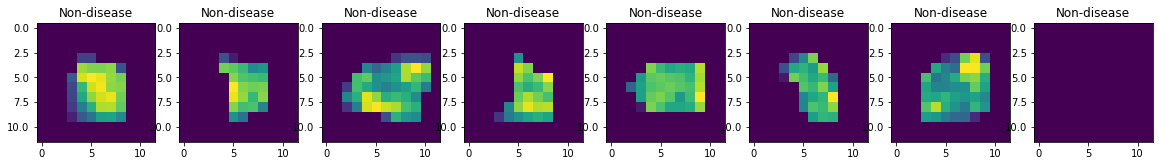

In [59]:
for train_sample in dataset:
    displayImgs(train_sample[0], train_sample[1], save=False)
    break

In [60]:
# Initialize network
model = ResNet(in_channels=in_channels, num_classes=num_classes).to(device)

In [61]:
# Load weights
model.load_state_dict(torch.load(os.getcwd() + "\\ResNet_downy_mildew_HSI_result\\downy_mildew_ResNet_HSI.pt"))

<All keys matched successfully>

In [62]:
model.eval()

ResNet(
  (conv1): Conv2d(14, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (downsample): Sequential(
    (0): Conv2d(14, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=1024, out_features=512, bias=Tru

In [63]:
# Predict 
def predict(loader, model, savefig=False):
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            displayImgs(x, predictions, savefig)
            break
    model.train()

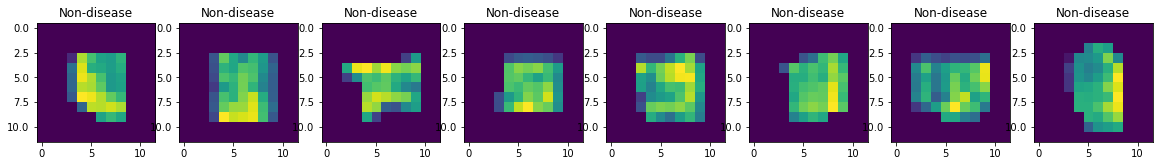

In [64]:
predict(dataset, model, savefig=True)

In [65]:
# Predict 
def predict2(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    model.train()
    
    return actual, prediction

In [66]:
actual, prediction = predict2(dataset, model)

In [67]:
print(actual)

[0. 0. 0. ... 1. 0. 1.]


In [68]:
print(prediction)

[0. 0. 0. ... 0. 0. 0.]


In [69]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual, prediction)
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

In [70]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["non-diseased", "diseased"])

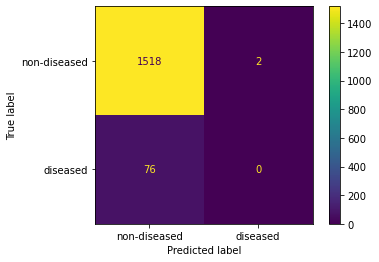

In [71]:
cm_display.plot()
plt.savefig('confusion_matrix.png')
plt.show()